In [ ]:
!pip install -U scikit-activeml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iteration-utilities: filename=iteration_utilities-0.11.0-cp310-cp310-linux_x86_64.whl size=327911 sha256=517607595d21e49daa5708a5b4e1c1e2a4742dee149671a8cfea6aac881e4beb
  Stored in directory: /root/.cache/pip/wheels/2d/ab/c4/309aa5942beba1f36d6744acf619b7a314fca50f6a7ccce68c
Successfully built iteration-utilities
  Attempting uninstall: joblib
    Found existing installation: joblib 1.3.2
    Uninstalling joblib-1.3.2:
      Successfully uninstalled joblib-1.3.2


In [ ]:
import numpy as np
from matplotlib import pyplot as plt, animation
from sklearn.datasets import make_blobs

from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_utilities, plot_decision_boundary

from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.pool import UncertaintySampling

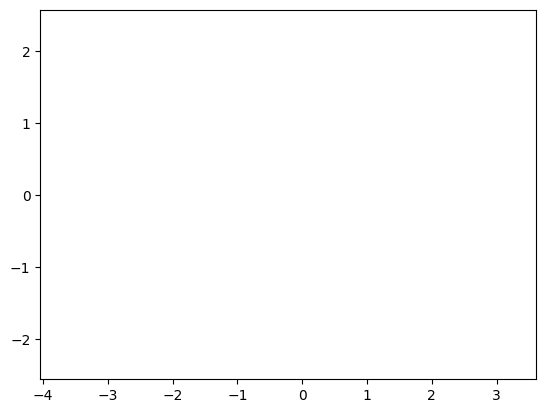

In [ ]:
random_state = np.random.RandomState(0)

 # Build a dataset.
X, y_true = make_blobs(n_samples=200, n_features=2,
                      centers=[[0, 1], [-3, .5], [-1, -1], [2, 1], [1, -.5]],
                      cluster_std=.7, random_state=random_state)

y_true = y_true % 2
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)


# Initialise the classifier.
clf = ParzenWindowClassifier(classes=[0, 1], random_state=random_state)

# Initialise the query strategy.
qs = UncertaintySampling(method='margin_sampling')


# Preparation for plotting.
fig, ax = plt.subplots()
feature_bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
artists = []


# The active learning cycle:
n_cycles = 20
for c in range(n_cycles):

    # Fit the classifier.
    clf.fit(X, y)

    # Get labeled instances.
    X_labeled = X[labeled_indices(y)]

    # Query the next instance/s.
    query_idx = qs.query(X=X, y=y, clf=clf)

    # Plot the labeled data.
    coll_old = list(ax.collections)

    title = ax.text(
        0.5, 1.05, f"Decision boundary after acquring {c} labels",
        size=plt.rcParams["axes.titlesize"], ha="center",
        transform=ax.transAxes
    )

    ax = plot_utilities(qs, X=X, y=y, clf=clf,
                        candidates=None, res=25,
                        feature_bound=feature_bound, ax=ax)

    ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap="coolwarm", marker=".",
              zorder=2)

    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c="grey", alpha=.8,
              marker=".", s=300)

    ax = plot_decision_boundary(clf, feature_bound, ax=ax)
    coll_new = list(ax.collections)
    coll_new.append(title)
    artists.append([x for x in coll_new if (x not in coll_old)])


    # Label the queried instances.
    y[query_idx] = y_true[query_idx]

ani = animation.ArtistAnimation(fig, artists, interval=1000, blit=True)